In [43]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [69]:
class Value:
    
    def __init__ (self, data, _children=(), _op="", label=""):
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self.data = data
        self._op = _op
        self.label=label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        result = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad = 1.0 * result.grad
            other.grad = 1.0 * result.grad
        result._backward = _backward
        
        return result
    
    def __mul__(self, other):
        result = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad = other.data * result.grad
            other.grad = self.data * result.grad
            
        result._backward = _backward
            
        return result
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        result = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1-t**2) * result.grad
            
        result._backward = _backward
            
        return result
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()
        
        
        


a = Value(2.0, label="a");
b = Value(5.0, label="b")
c = Value(10, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2, label='f')
L = d * f; L.label='L'

In [45]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



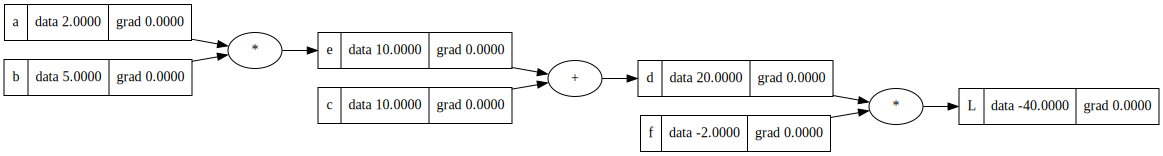

In [46]:
draw_dot(L)

In [59]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.5, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()

In [51]:
o.grad = 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()

In [65]:
o.grad = 1.0

In [70]:
o.backward()
draw_dot(o)

AttributeError: 'Value' object has no attribute 'backward'